# Imports and paths

In [6]:
import os
import sys

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

import polars as pl
import pandas as pd
import numpy as np
import json

In [2]:
from config import TRAIN_PARQUET_PATH, TEST_PARQUET_PATH, PRODUCTS_PARQUET_PATH, USERS_DATA_PATH, PRODUCTS_PARQUET_PATH_IMPUTED, ALL_PRODS_TRAINTEST_PATH
from src.data.loaders import PolarsLoader

## Products

In [9]:
prods = pl.read_parquet(PRODUCTS_PARQUET_PATH, low_memory=True)
print(prods.shape)
print(prods.head())
print(prods.null_count())

(43692, 6)
shape: (5, 6)
┌──────────┬─────────────────────────────────┬────────────┬──────────┬─────────────┬────────┐
│ discount ┆ embedding                       ┆ partnumber ┆ color_id ┆ cod_section ┆ family │
│ ---      ┆ ---                             ┆ ---        ┆ ---      ┆ ---         ┆ ---    │
│ u8       ┆ list[f32]                       ┆ u16        ┆ u16      ┆ u8          ┆ u16    │
╞══════════╪═════════════════════════════════╪════════════╪══════════╪═════════════╪════════╡
│ 0        ┆ [-0.134014, -0.120043, … -0.08… ┆ 32776      ┆ 85       ┆ 4           ┆ 73     │
│ 0        ┆ [-0.094927, -0.107294, … -0.04… ┆ 41431      ┆ 135      ┆ 4           ┆ 73     │
│ 0        ┆ [-0.129044, -0.077246, … 0.002… ┆ 39419      ┆ 339      ┆ 4           ┆ 73     │
│ 1        ┆ [-0.127833, -0.133868, … -0.09… ┆ 36087      ┆ 135      ┆ 4           ┆ 73     │
│ 1        ┆ [-0.140929, -0.125828, … -0.04… ┆ 34132      ┆ 3        ┆ 4           ┆ 73     │
└──────────┴───────────────────────

In [10]:
prods['partnumber'].n_unique()

43692

### Drop products not present in the training/test set

In [11]:
# Load from JSON
with open(ALL_PRODS_TRAINTEST_PATH, 'r') as f:
    all_prods = json.load(f)

prods = prods.filter(pl.col('partnumber').is_in(all_prods))
prods['partnumber'].n_unique()

42265

### Null imputation

**Family mean (embedding)**

In [12]:
from typing import List
# # Helper function to calculate mean embedding for a group
def calc_mean_embedding(embeddings: List[np.ndarray]) -> np.ndarray:
    valid_embeddings = [e for e in embeddings if e is not None and len(e) > 0]
    return np.mean(valid_embeddings, axis=0) if valid_embeddings else np.nan

# Calculate family mean embeddings
family_means = (
    prods
    .group_by('family')
    .agg(pl.col('embedding'))
    .with_columns(
        mean_embedding=pl.col('embedding').map_elements(calc_mean_embedding, return_dtype=pl.List(pl.Float32))
    )
)

In [13]:
prods = prods.join(family_means.select(['family', 'mean_embedding']), on='family', how='left')
prods = prods.with_columns([
    pl.when(pl.col('embedding').is_null())
        .then(pl.col('mean_embedding'))
        .otherwise(pl.col('embedding'))
        .alias('embedding')
])
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family,mean_embedding
u32,u32,u32,u32,u32,u32,u32
0,8,0,0,87,0,8


**Overall mean (embedding)**

In [14]:
# Calculate family mean embeddings
overall_mean = calc_mean_embedding(prods['embedding'])
overall_mean

array([-0.08372563,  0.16689125, -0.10456386, ...,  0.15249544,
        0.00691349,  0.04625465], shape=(1280,), dtype=float32)

In [15]:
prods = prods.with_columns([
    pl.when(pl.col("embedding").is_null())
        .then(pl.lit(pl.Series([overall_mean])))  # Convert numpy array to Polars Series
        .otherwise(pl.col('embedding'))
        .alias('embedding')
]).drop('mean_embedding')
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family
u32,u32,u32,u32,u32,u32
0,0,0,0,87,0


In [16]:
# # Inspect lengths of embeddings
# prods_imputed = prods.to_pandas()
# embedding_lengths = prods_imputed['embedding'].apply(lambda x: len(x) if x is not None else None)

# # Check for unique lengths
# print(embedding_lengths.unique())  # Should ideally show one value, e.g., [1280]

# # Find problematic rows (if any)
# problematic_rows = prods_imputed[embedding_lengths != 1280]
# print(problematic_rows)

**cod_section**

In [17]:
def fill_section_mode(products):
    # Calculate mode by family
    family_modes = (
        products.group_by('family')
        .agg(
            mode_section=pl.col('cod_section').cast(pl.String).mode().first()
        )
    )

    # Join back to fill nulls
    result = products.join(
        family_modes,
        on='family',
        how='left'
    ).with_columns(
        cod_section=pl.col('cod_section').fill_null(pl.col('mode_section').cast(pl.UInt8))
    ).drop('mode_section')

    return result

In [18]:
prods = fill_section_mode(prods)
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


In [20]:
# prods.write_parquet(PRODUCTS_PARQUET_PATH_IMPUTED)

### PCA embeddings

In [317]:
# prods_imputed = prods.clone()

In [21]:
prods_imputed = pl.read_parquet(PRODUCTS_PARQUET_PATH_IMPUTED)
prods_imputed.head()

discount,embedding,partnumber,color_id,cod_section,family
u8,list[f32],u16,u16,u8,u16
0,"[-0.134014, -0.120043, … -0.080103]",32776,85,4,73
0,"[-0.094927, -0.107294, … -0.044575]",41431,135,4,73
0,"[-0.129044, -0.077246, … 0.002047]",39419,339,4,73
1,"[-0.127833, -0.133868, … -0.091194]",36087,135,4,73
1,"[-0.140929, -0.125828, … -0.043056]",34132,3,4,73


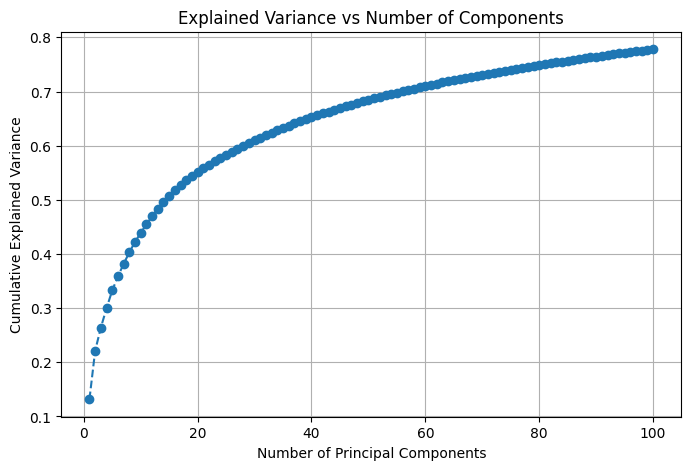

Number of components to retain 95% variance: 1


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'products['embedding']' contains the embeddings as lists of floats
embeddings = np.stack(prods_imputed['embedding'].to_numpy())

# Normalize embeddings to ensure consistency
normalized_embeddings = normalize(embeddings)

# Apply PCA
pca = PCA(n_components=100)
pca.fit(normalized_embeddings)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()

# Determine the number of components for 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

## Train and test processing

In [67]:
loader = PolarsLoader(sampling=False, file_type='parquet')
train = loader.load_data(path=TRAIN_PARQUET_PATH)
test = loader.load_data(path=TEST_PARQUET_PATH)
train.head()

session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype
u32,date,datetime[μs],u8,u32,u8,u16,u8,u8
64,2024-06-06,2024-06-06 16:43:17.389,0,null,29,14327,1,24
117,2024-06-08,2024-06-08 15:11:02.782,0,null,57,38422,1,24
117,2024-06-08,2024-06-08 15:11:44.797,0,null,57,19763,1,24
579,2024-06-05,2024-06-05 19:24:48.397,0,null,29,30253,1,24
1220,2024-06-04,2024-06-04 08:21:13.476,0,480729,25,1592,1,24


In [68]:
# Testing candidates merging 
top_100_parts = all_prods[:10]
top_100_parts

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [69]:
test

session_id,date,timestamp_local,user_id,country,partnumber,device_type,pagetype
u32,date,datetime[μs],u32,u8,u16,u8,u8
746,2024-06-15,2024-06-15 18:36:47.390,null,57,1254,1,24
746,2024-06-15,2024-06-15 18:37:04.052,null,57,32544,1,24
746,2024-06-15,2024-06-15 18:37:48.159,null,57,12639,1,24
746,2024-06-15,2024-06-15 18:38:19.899,null,57,18048,1,24
746,2024-06-15,2024-06-15 18:38:46.492,null,57,13295,1,24
…,…,…,…,…,…,…,…
5167195,2024-06-16,2024-06-16 13:13:10.152,null,34,30113,1,24
5167272,2024-06-16,2024-06-16 18:58:15.562,null,34,28922,1,8
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24


In [70]:
# Generar todas las combinaciones
candidates = [
    {"session_id": sid, "partnumber": pn}
    for sid in test["session_id"].unique()
    for pn in top_100_parts
]

# Convertir a Polars DataFrame
candidates_df = pl.DataFrame(candidates).with_columns(pl.col("session_id").cast(pl.UInt32))
candidates_df

session_id,partnumber
u32,i64
746,1
746,2
746,3
746,4
746,5
…,…
5168933,6
5168933,7
5168933,8


In [ ]:
# Hacer el merge
result = test.join(
    candidates_df,
    on="session_id",
    how="full",
)
result\
.filter(pl.col("session_id") == 5168338)

session_id,date,timestamp_local,user_id,country,partnumber,device_type,pagetype,partnumber_right
u32,date,datetime[μs],u32,u8,u16,u8,u8,i64
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,1
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,2
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,3
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,4
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,5
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,6
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,7
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,8
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24,9


In [73]:
# Crear DataFrame de partnumbers
part_df = pl.DataFrame({
    "partnumber": top_100_parts
})

# Crear DataFrame único de sessions
sessions_df = test.select("session_id").unique()

# Hacer cross join
candidates_df = sessions_df.join(
    part_df,
    how="cross"
)

# Merge final con el test dataset
result = test.join(
    candidates_df,
    on="session_id",
    how="inner"
)

result

session_id,date,timestamp_local,user_id,country,partnumber,device_type,pagetype,partnumber_right
u32,date,datetime[μs],u32,u8,u16,u8,u8,i64
488564,2024-06-16,2024-06-16 03:41:01.605,null,34,23304,1,24,1
488564,2024-06-16,2024-06-16 03:41:36.726,null,34,23303,1,24,1
488564,2024-06-16,2024-06-16 03:42:04.824,null,34,34289,1,24,1
488564,2024-06-16,2024-06-16 03:42:17.787,null,34,16585,1,24,1
488564,2024-06-16,2024-06-16 03:42:26.504,null,34,23304,1,24,1
…,…,…,…,…,…,…,…,…
3254841,2024-06-16,2024-06-16 02:34:45.587,null,34,9520,1,24,10
3254841,2024-06-16,2024-06-16 02:34:50.794,null,34,22302,1,24,10
3254841,2024-06-16,2024-06-16 02:35:03.153,null,34,9520,1,24,10


In [65]:
# Hacer el merge
result = test.join(
    candidates_df,
    on="session_id",
    how="full"
)
result

session_id,date,timestamp_local,user_id,country,partnumber,device_type,pagetype,session_id_right,partnumber_right
u32,date,datetime[μs],u32,u8,u16,u8,u8,u32,i64
746,2024-06-15,2024-06-15 18:36:47.390,null,57,1254,1,24,746,1
746,2024-06-15,2024-06-15 18:37:04.052,null,57,32544,1,24,746,1
746,2024-06-15,2024-06-15 18:37:48.159,null,57,12639,1,24,746,1
746,2024-06-15,2024-06-15 18:38:19.899,null,57,18048,1,24,746,1
746,2024-06-15,2024-06-15 18:38:46.492,null,57,13295,1,24,746,1
…,…,…,…,…,…,…,…,…,…
5168933,2024-06-16,2024-06-16 04:53:26.427,null,57,8969,1,24,5168933,6
5168933,2024-06-16,2024-06-16 04:53:26.427,null,57,8969,1,24,5168933,7
5168933,2024-06-16,2024-06-16 04:53:26.427,null,57,8969,1,24,5168933,8


In [4]:
# Save products in train/test to reduce product dataset
train_prods = train.select('partnumber').unique()
train_prods = list(train_prods.to_series())

test_prods = test.select('partnumber').unique()
test_prods = list(test_prods.to_series())

print("Total number of products in train + test datasets: ", len(set(train_prods + test_prods)))

Total number of products in train + test datasets:  42265


In [5]:
import json

all_prods = list(set(train_prods + test_prods))

# Save to JSON
with open(ALL_PRODS_TRAINTEST_PATH, 'w') as f:
    json.dump(all_prods, f)

In [33]:
def impute_train_test(df):
    
    return df.with_columns([pl.col("user_id").fill_null(-1).cast(pl.Int32),
                        pl.col("pagetype").fill_null(pl.col("pagetype").mode()),
                        ])

train = impute_train_test(train)
test = impute_train_test(test)

In [34]:
# # Is each session from a single user? SI
# train.drop_nulls()\
#     .group_by('session_id')\
#         .agg(pl.col('user_id').n_unique())\
#             .sort('user_id', descending=True)

In [52]:
# Some session with several interactions
train.drop_nulls()\
    .group_by('session_id')\
        .agg(pl.col('user_id').count())\
            .sort('user_id', descending=True)\
                .filter(pl.col('user_id') >= 30)

session_id,user_id
u32,u32
3745893,6480
205622,2022
2247260,1619
2656537,1132
3058982,1115
…,…
2473080,30
4965569,30
438060,30


In [ ]:
# 2 FEATURES IMPORTANTES A CREAR
# 1. Cuanto duro cada interaccion
# 2. Si es la primera interaccion con el producto o que numero es

def feature_engineering(df):

    # Cleaning and sorting
    df_ = (df.clone()
           .drop("date")
           .sort("timestamp_local")
    )

    # df_ = df_.with_columns([
    #     # Calculate the difference in timestamps within each session
    #     (pl.col("timestamp_local").diff().over("session_id").cast(pl.Float32) / 1_000_000).alias("seconds_since_last_interaction"),
    #     # Total session duration in seconds
    #     ((pl.col("timestamp_local").max() - pl.col("timestamp_local").min()).over("session_id").cast(pl.Float32) / 1_000_000).alias("total_session_time"),

    #     # Assign a cumulative count for each partnumber within a session
    #     pl.col("partnumber").cum_count().over(["session_id", "partnumber"]).alias("product_interaction_count")
    # ]).fill_null(strategy="zero")

    # df_ = df_.with_columns([
    #             pl.col("seconds_since_last_interaction").shift(-1).over("session_id").alias("interaction_length"),
    # ]).fill_null(strategy="zero")

    # # Date features
    # df_ = df_.with_columns([
    #     # Extracting day number
    #     pl.col("timestamp_local").dt.day().alias("day_number"),
        
    #     # Extracting weekday number
    #     pl.col("timestamp_local").dt.weekday().alias("weekday_number"),
        
    #     # Extracting weekday name
    #     pl.col("timestamp_local").dt.strftime("%A").alias("weekday_name").cast(pl.Categorical),
        
    #     # Extracting hour
    #     pl.col("timestamp_local").dt.hour().alias("hour")
    # ])

    # def get_day_frame(hour: int) -> int:
    #     if 6 <= hour < 12:
    #         return 0  # Morning
    #     elif 12 <= hour < 18:
    #         return 1  # Afternoon
    #     elif 18 <= hour < 24:
    #         return 2  # Night
    #     else:
    #         return 3  # Late Night
        
    # df_ = df_.with_columns([
    #                 pl.col("hour").map_elements(get_day_frame, return_dtype=pl.UInt8).alias("day_frame")
    #             ])

    return df_

train_eng = feature_engineering(train)
test_eng = feature_engineering(test)

In [65]:
df = train_eng.filter(pl.col('session_id') == 2473080).sort('timestamp_local')
print(df['add_to_cart'].sum())
df

3


session_id,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype,seconds_since_last_interaction,total_session_time,product_interaction_count,interaction_length,day_number,weekday_number,weekday_name,hour,day_frame
u32,datetime[μs],u8,i32,u8,u16,u8,u8,f32,f32,u32,f32,i8,i8,cat,i8,u8
2473080,2024-06-03 18:18:49.354,0,555107,25,3538,1,24,0.0,562.494019,1,20.379,3,1,"""Monday""",18,2
2473080,2024-06-03 18:19:09.733,0,555107,25,1179,1,24,20.379,562.494019,1,6.371,3,1,"""Monday""",18,2
2473080,2024-06-03 18:19:16.104,0,555107,25,26292,1,24,6.371,562.494019,1,3.676,3,1,"""Monday""",18,2
2473080,2024-06-03 18:19:19.780,0,555107,25,1179,1,24,3.676,562.494019,2,4.217,3,1,"""Monday""",18,2
2473080,2024-06-03 18:19:23.997,0,555107,25,31762,1,24,4.217,562.494019,1,3.186,3,1,"""Monday""",18,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2473080,2024-06-03 18:27:24.307,0,555107,25,24709,1,24,0.928,562.494019,1,1.707,3,1,"""Monday""",18,2
2473080,2024-06-03 18:27:26.014,0,555107,25,39439,1,24,1.707,562.494019,1,9.912,3,1,"""Monday""",18,2
2473080,2024-06-03 18:27:35.926,1,555107,25,24271,1,24,9.912,562.494019,2,16.382999,3,1,"""Monday""",18,2


Useful information:

In [66]:
print("*"*50)
print("TRAIN DATA:")
print("*"*50)
print("Unique session IDs")
print(train['session_id'].n_unique())

print("\nNumber of interacted products")
print(train['partnumber'].n_unique())

print("\nDate range:")
print(train['date'].min())
print(train['date'].max()) #----> Extraer entonces solo: NUMERO DIA, NUMERO DIA DE LA SEMANA, NOMBRE DIA DE LA SEMANA, NUMERO HORA, MAÑANA/TARDE/NOCHE

print("\n","*"*50)
print("TEST DATA:")
print("*"*50)
print("Unique session IDs")
print(test['session_id'].n_unique())

print("\nNumber of interacted products")
print(test['partnumber'].n_unique())

print("\nDate range:")
print(test['date'].min())
print(test['date'].max())

**************************************************
TRAIN DATA:
**************************************************
Unique session IDs
95364

Number of interacted products
26380

Date range:
2024-06-01
2024-06-15

 **************************************************
TEST DATA:
**************************************************
Unique session IDs
7349

Number of interacted products
9253

Date range:
2024-06-15
2024-06-16


In [6]:
test.null_count()

session_id,date,timestamp_local,user_id,country,partnumber,device_type,pagetype
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,23509,0,0,0,0


In [15]:
test

session_id,date,timestamp_local,user_id,country,partnumber,device_type,pagetype
u32,date,datetime[μs],u32,u8,u16,u8,u8
746,2024-06-15,2024-06-15 18:36:47.390,null,57,1254,1,24
746,2024-06-15,2024-06-15 18:37:04.052,null,57,32544,1,24
746,2024-06-15,2024-06-15 18:37:48.159,null,57,12639,1,24
746,2024-06-15,2024-06-15 18:38:19.899,null,57,18048,1,24
746,2024-06-15,2024-06-15 18:38:46.492,null,57,13295,1,24
…,…,…,…,…,…,…,…
5167195,2024-06-16,2024-06-16 13:13:10.152,null,34,30113,1,24
5167272,2024-06-16,2024-06-16 18:58:15.562,null,34,28922,1,8
5168338,2024-06-15,2024-06-15 21:36:15.931,null,34,13467,1,24


In [7]:
print(train.shape, test.shape)

(46551445, 9) (29275, 8)


In [16]:
train.null_count()

session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,39694715,0,0,0,1197


In [23]:
df = train.filter(pl.col('session_id') == 2076921).sort('timestamp_local')
df

session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype
u32,date,datetime[μs],u8,u32,u8,u16,u8,u8
2076921,2024-06-11,2024-06-11 23:47:51.411,0,null,29,37857,3,24
2076921,2024-06-11,2024-06-11 23:48:18.931,0,null,29,34242,3,24
2076921,2024-06-11,2024-06-11 23:48:21.063,0,null,29,5785,3,24
2076921,2024-06-11,2024-06-11 23:48:24.248,0,null,29,34242,3,24
2076921,2024-06-11,2024-06-11 23:48:25.571,0,null,29,29424,3,24
…,…,…,…,…,…,…,…,…
2076921,2024-06-11,2024-06-11 23:50:52.886,0,null,29,3076,3,24
2076921,2024-06-11,2024-06-11 23:51:04.643,0,null,29,12641,3,24
2076921,2024-06-11,2024-06-11 23:51:10.625,1,null,29,3076,3,24


In [24]:
df['partnumber'].value_counts()

partnumber,count
u16,u32
5667,1
29424,3
5785,1
12641,1
37857,1
3076,3
28617,1
4774,1
34242,5


In [31]:
df.group_by('session_id').agg(pl.col('partnumber').count())

session_id,partnumber
u32,u32
2076921,17


## Users data

In [33]:
users = pl.read_parquet(USERS_DATA_PATH, low_memory=True).rename({'country': 'user_country'})
print(users.head())
print(users.null_count())

shape: (5, 5)
┌──────────────┬─────┬─────┬───────────┬─────────┐
│ user_country ┆ R   ┆ F   ┆ M         ┆ user_id │
│ ---          ┆ --- ┆ --- ┆ ---       ┆ ---     │
│ u8           ┆ u16 ┆ u16 ┆ f32       ┆ u32     │
╞══════════════╪═════╪═════╪═══════════╪═════════╡
│ 25           ┆ 30  ┆ 0   ┆ 0.0       ┆ 430102  │
│ 25           ┆ 177 ┆ 1   ┆ 75.900002 ┆ 134198  │
│ 25           ┆ 32  ┆ 61  ┆ 37.694057 ┆ 134207  │
│ 25           ┆ 74  ┆ 86  ┆ 11.64094  ┆ 180365  │
│ 25           ┆ 79  ┆ 5   ┆ 30.283333 ┆ 430101  │
└──────────────┴─────┴─────┴───────────┴─────────┘
shape: (1, 5)
┌──────────────┬─────┬─────┬─────┬─────────┐
│ user_country ┆ R   ┆ F   ┆ M   ┆ user_id │
│ ---          ┆ --- ┆ --- ┆ --- ┆ ---     │
│ u32          ┆ u32 ┆ u32 ┆ u32 ┆ u32     │
╞══════════════╪═════╪═════╪═════╪═════════╡
│ 0            ┆ 0   ┆ 0   ┆ 0   ┆ 0       │
└──────────────┴─────┴─────┴─────┴─────────┘
